In [1]:
!pip install torchtext
!pip install -U spacy
!python -m spacy download en

    100% |████████████████████████████████| 71kB 4.7MB/s 
    100% |████████████████████████████████| 591.8MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x611a8000 @  0x7fd8af9f02a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.18)
    100% |████████████████████████████████| 13.9MB 2.7MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfull

In [0]:
import math
import torch
from torchtext import data
from torchtext import datasets
import random
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #for reproducible results

In [0]:
MAX_DOCUMENT_LEN = 900

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.compile('<.*?>').sub(" ", text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    #text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    text = text.split()
    return text

In [0]:
TEXT = data.Field(tokenize=clean_text,lower=True)    
LABEL = data.LabelField(dtype = torch.float)

In [0]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(text_field=TEXT,label_field=LABEL)
train_data, valid_data = train_data.split(split_ratio= 0.8, random_state=random.seed(SEED))

In [31]:
print('Number of training examples: {}'.format(len(train_data)))
print('Number of validation examples: {}'.format(len(valid_data)))
print(vars(train_data[0]))

Number of training examples: 20000
Number of validation examples: 5000
{'text': ['this', 'is', 'not', 'an', 'entirely', 'bad', 'movie', 'the', 'plot', 'new', 'house', 'built', 'next', 'door', 'seems', 'to', 'be', 'haunted', 'is', 'not', 'bad', 'the', 'mood', 'is', 'creepy', 'enough', 'and', 'the', 'acting', 'is', 'okay', 'the', 'big', 'problem', 'i', 'had', 'is', 'that', 'being', 'familiar', 'with', 'lara', 'flynn', 'boyle', 'from', 'twin', 'peaks', 'and', 'other', 'shows', 'i', "couldn't", 'get', 'over', 'how', 'different', 'she', 'looks', 'with', 'her', 'apparently', 'new', 'big', 'lips', 'i', 'kept', 'staring', 'at', 'them', 'they', 'look', 'so', 'out', 'of', 'place', 'on', 'her', 'face!', 'they', 'make', 'her', 'look', 'completely', 'different', 'and', 'not', 'better', 'markpaul', 'gosselaar', 'the', 'actor', 'who', 'plays', 'kim', 'the', 'architect', 'who', 'designs', 'and', 'pours', 'his', 'heart', 'and', 'soul', 'into', 'the', 'house', 'does', 'a', 'fine', 'job', 'and', 'lara', 

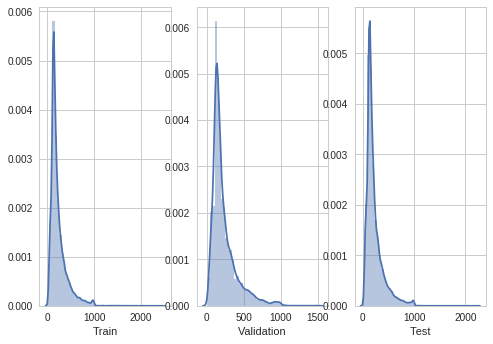

In [32]:
train_data_dist = [len(train_data[i].text) for i in range(len(train_data))]
valid_data_dist = [len(valid_data[i].text) for i in range(len(valid_data))]
test_data_dist = [len(test_data[i].text) for i in range(len(test_data))]

sns.set(style='whitegrid')
f, axes = plt.subplots(1, 3)

sns.distplot(a = train_data_dist,ax=axes[0], axlabel='Train')
sns.distplot(a = valid_data_dist,ax=axes[1], axlabel='Validation')
sns.distplot(a = test_data_dist,ax=axes[2], axlabel='Test')

In [0]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


### Convolutional Feature Extractor


This feature extractor module is doesn't come into usage, but as the paper had a section on the extraction of Q(query), K(key), V(value) from the embeddings using1-Dimensional convolution, therefore the module is as follows.

In [0]:
class ConvQ(nn.Module):
    def __init__(self,vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cnn_q = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_k = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_v = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
    def forward(self,x):
        #x = [seq_len, batch_size]
        x = x.permute(1,0)                 # x = [batch, seq_len]
        embedded = self.embedding(x)       # embedding = [batch, seq_len, emd_dim]
        embedded = embedded.permute(0,2,1) # embedding = [batch, emd_dim, seq_len]
        q = (F.elu(self.cnn_q(embedded)))  # q = [batch, emd_dim, seq_len-2]
        k = (F.elu(self.cnn_k(embedded)))  # k = [batch_Size, emd_dim, seq_len-2]
        v = (F.elu(self.cnn_v(embedded)))  # v = [batch_Size, emd_dim, seq_len-2]
                                           
        return q, k, v
        


### Convolutional Singlehead Self-Attention(ELU)


In [0]:
class SingleSelfAttnELU(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.cnn_q = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_k = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_v = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)

        self.softmax = nn.Softmax(dim=2)
           
    def forward(self, x):
        q = (F.elu(self.cnn_q(x))) 
        k = (F.elu(self.cnn_k(x)))
        v = (F.elu(self.cnn_v(x))) 
                # q = [batch_Size, emd_dim, seq_len]
                # k = [batch_Size, emd_dim, seq_len]
                # v = [batch_Size, emd_dim, seq_len]

        a = torch.bmm(q.permute(0,2,1), k)      # a = [batch, seq_len, seq_len]
        a = self.softmax(a/q.size(1)**0.5)     # a = [batch, seq_len, seq_len]
        
        output = torch.bmm(a,v.permute(0,2,1))  # output= [batch, seq_len, emd_dim]
        
        return output

### Convolutional Multihead Self-Attention(ELU)

In [0]:
class MultiSelfAttnELU(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.cnn_q = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_k = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_v = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)

        
        self.softmax=nn.Softmax(dim=2)
        
    def forward(self, x):
        q = (F.elu(self.cnn_q(x)))  
        k = (F.elu(self.cnn_q(x))) 
        v = (F.elu(self.cnn_q(x)))  
                # q = [batch_Size, emd_dim, seq_len]
                # k = [batch_Size, emd_dim, seq_len]
                # v = [batch_Size, emd_dim, seq_len]
        
        q = torch.chunk(q, self.num_heads, 1)
        k = torch.chunk(k, self.num_heads, 1)
        v = torch.chunk(v, self.num_heads, 1)
        heads = []
        for i in range(len(q)):
            a = torch.bmm(q[i].permute(0,2,1), k[i])
            a = self.softmax(a/q[i].size(1)**0.5)
          
            h = torch.bmm(a, v[i].permute(0, 2, 1))
            heads.append(h)
        
        output = torch.cat(tuple(heads),dim = -1)
        return output # output = [batch_size, seq_len, emd_dim]
        

### Convolutional Multihead Self-Attention(Tanh)

In [0]:
class MultiSelfAttnTANH(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.cnn_q = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_k = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_v = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)

        
        self.softmax=nn.Softmax(dim=2)
        
    def forward(self, x):
        q = (F.elu(self.cnn_q(x)))  
        k = (F.elu(self.cnn_q(x))) 
        v = (torch.tanh(self.cnn_q(x)))  
                # q = [batch_Size, emd_dim, seq_len]
                # k = [batch_Size, emd_dim, seq_len]
                # v = [batch_Size, emd_dim, seq_len]
        
        q = torch.chunk(q, self.num_heads, 1)
        k = torch.chunk(k, self.num_heads, 1)
        v = torch.chunk(v, self.num_heads, 1)
        heads = []
        for i in range(len(q)):
            a = torch.bmm(q[i].permute(0,2,1), k[i])
            a = self.softmax(a/q[i].size(1)**0.5)
          
            h = torch.bmm(a, v[i].permute(0, 2, 1))
            heads.append(h)
        
        output = torch.cat(tuple(heads),dim = -1)
        return output # output = [batch, seq_len, emd_dim]
        

### Convolutional Multihead Target-Attention

In [0]:
class MultiTgtAttn(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.target = nn.Parameter(torch.rand(1,embedding_dim))
        stdv = 1. / math.sqrt(self.target.size(1))
        self.target.data.uniform_(-stdv, stdv)
        self.cnn_k = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.cnn_v = nn.Conv1d(in_channels = embedding_dim, out_channels = embedding_dim, kernel_size=3)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        # x = [batch_size, emd_dim, seq_len]
        k = self.cnn_k(x)
        v = self.cnn_v(x)
        t = self.target
        
        k = torch.chunk(k, self.num_heads, 1)
        v = torch.chunk(v, self.num_heads, 1)
        t = torch.chunk(t, self.num_heads, 1)
        heads = []
        for i in range(len(k)):
          
            a = F.linear(k[i].permute(0,2,1), t[i])
            a = self.softmax(a/k[i].size(1)**0.5)
            h = torch.bmm(a.permute(0,2,1), v[i].permute(0,2,1)).squeeze(1)
            heads.append(h)
        output = torch.cat(tuple(heads), dim=-1)
        return output #[batch, emd_dim]

### Multi-Channel Convolutional Classification

In [0]:
class CNN(nn.Module):
    def __init__(self,vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.atten = SingleSelfAttnELU(embedding_dim)             #put self.atten = MultiSelfAttnELU() for multihead attention 
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0],embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2],embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        # x = [seq_len, batch_size]
        x = x.permute(1,0)                 # x = [batch, seq_len]
        embedded = self.embedding(x)       # embedding = [batch_size, seq_len, emd_dim]
        embedded = embedded.permute(0,2,1) # embedding = [batch_size, emd_dim, seq_len]
        
      
        
        
        output = self.atten(embedded)   # output = [batch, seq_len, emd_dim]
        output = output.unsqueeze(1)    # output = [batch, 1, seq_length, emd_dim]

        
        conved_0 = F.relu(self.conv_0(output).squeeze(3))         
        conved_1 = F.relu(self.conv_1(output).squeeze(3))
        conved_2 = F.relu(self.conv_2(output).squeeze(3))
        
                             # conv_n = [batch, n_filters, sent len - filter_sizes[n]]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
                             # pooled_n = [batch, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

                             # cat = [batch, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

### Maxpool FC

In [0]:
class Maxpool(nn.Module):
    def __init__(self,vocab_size, embedding_dim,output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.atten = SingleSelfAttnELU(embedding_dim) #put self.atten = MultiSelfAttnELU() for multihead attention 
        self.fc = nn.Linear(embedding_dim, output_dim)
      

    def forward(self, x):
        # x = [seq_len, batch_size]
        x = x.permute(1,0)                 # x = [batch, seq_len]
        embedded = self.embedding(x)       # embedding = [batch, seq_len, emd_dim]
        embedded = embedded.permute(0,2,1) # embedding = [batch, emd_dim, seq_len]
        
      
        
        
        output = self.atten(embedded)      # output = [batch, seq_len, emd_dim]
        output = output.permute(0,2,1)     # output = [batch, emd_dim, seq_len]
       
        pooled = F.max_pool1d(output, output.shape[-1]).squeeze(-1)  
                                                               
        # pooled = [batch, emd_dim]
            
        return self.fc(pooled)

In [0]:
class Network(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, output_dim)
        self.attnelu = MultiSelfAttnELU(embedding_dim, num_heads)
        self.attntanh = MultiSelfAttnTANH(embedding_dim, num_heads)
        self.mta = MultiTgtAttn(embedding_dim, num_heads)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, x):
        #x = [seq_len, batch_size]
        x = x.permute(1,0)
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1) # embedding = [batch, emd_dim, seq_len]
        
        elu = self.attnelu(embedded)
        tanh = self.attntanh(embedded)
        
        inp = elu*tanh
        inp = inp.permute(0,2,1)
        
        out = self.mta(inp)    #[batch, emd_dim]
        
        out = self.fc(out)
        return out
       
         

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
BATCH_SIZE = 4
NUM_HEADS = 5
#model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
#model = Maxpool(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM)
model = Network(INPUT_DIM, EMBEDDING_DIM, NUM_HEADS, OUTPUT_DIM)

In [44]:
pretrained_embeddings  = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3971, -0.3226, -0.2672,  ..., -0.2575, -0.0519,  0.5823],
        [ 0.2112, -0.3741,  0.1258,  ...,  0.0768, -0.3270,  0.0697],
        [ 0.0152, -0.6117,  0.2832,  ..., -0.5245, -0.2323, -0.4019]])

In [0]:
'''
def binary_accuracy(preds,y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    acc = correct.sum()/len(correct)
    return acc
'''
def precision_recall_f1(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    tp = y*rounded_preds
    fp = (y==0).float()*rounded_preds
    tn = (y==0).float()*(rounded_preds==0).float()
    fn = y*(rounded_preds==0).float()
    
    return sum(tp), sum(fp), sum(tn), sum(fn)      

  
def train(model, iterator, optimizer, criterion):
        
    epoch_loss= 0
    epoch_acc = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
        
    model.train()
        
    for batch in iterator:          
        optimizer.zero_grad()
            
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        #acc = binary_accuracy(predictions, batch.label)
        a, b, c, d = precision_recall_f1(predictions, batch.label)
       
        loss.backward() 
        optimizer.step()
            
        epoch_loss += loss.item()
        #epoch_acc +=acc.item()
        tp += a.item()
        fp += b.item()
        tn += c.item()
        fn += d.item()
            
    return epoch_loss/len(iterator), tp, fp, tn, fn
      
      
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            #acc = binary_accuracy(predictions, batch.label)
            a, b, c, d = precision_recall_f1(predictions, batch.label)
            
            tp += a.item()
            fp += b.item()
            tn += c.item()
            fn += d.item()
            epoch_loss += loss.item()
            #epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), tp, fp, tn, fn

In [0]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data,valid_data,test_data), batch_size=BATCH_SIZE,device=device)


In [47]:
N_EPOCHS = 3

for epoch in tqdm(range(N_EPOCHS)):
    model.embedding.weight.requires_grad=True
    if epoch>0:
        model.embedding.weight.requires_grad=False
        lr = 0.0001
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    train_loss, train_tp, train_fp, train_tn, train_fn = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_tp, valid_fp, valid_tn, valid_fn = evaluate(model, valid_iterator, criterion)
    train_acc = (train_tp+train_tn)/(train_tp+train_fp+train_fn+train_tn)
    valid_acc = (valid_tp+valid_tn)/(valid_tp+valid_fp+valid_fn+valid_tn)
    valid_precision = valid_tp/(valid_tp+valid_fp)
    valid_recall = valid_tp/(valid_tp+valid_fn)
    valid_f1= (2*valid_precision*valid_recall)/(valid_precision+valid_recall)
    print('| Epoch: {} | Train Loss: {:0.2f} | Train Acc: {:0.2f} | Val. Loss: {:0.2f} | Val. Acc: {:0.2f} | Val. F1 {:0.2f} |'.format(epoch+1,train_loss, train_acc*100,valid_loss, valid_acc*100, valid_f1))


 33%|███▎      | 1/3 [02:53<05:46, 173.03s/it]

| Epoch: 1 | Train Loss: 0.37 | Train Acc: 84.59 | Val. Loss: 0.30 | Val. Acc: 89.38 | Val. F1 0.90 |



 67%|██████▋   | 2/3 [05:34<02:49, 169.67s/it]

| Epoch: 2 | Train Loss: 0.17 | Train Acc: 94.25 | Val. Loss: 0.36 | Val. Acc: 89.92 | Val. F1 0.90 |



100%|██████████| 3/3 [08:16<00:00, 167.37s/it]


| Epoch: 3 | Train Loss: 0.16 | Train Acc: 94.53 | Val. Loss: 0.34 | Val. Acc: 89.92 | Val. F1 0.90 |


In [0]:
test_loss, test_tp, test_fp, test_tn, test_fn= evaluate(model, test_iterator, criterion)
test_acc = (test_tp+test_tn)/(test_tp+test_fp+test_fn+test_tn)
test_precision = test_tp/(test_tp+test_fp)
test_recall = test_tp/(test_tp+test_fn)
test_f1 = (2*test_precision*test_recall)/(test_precision+test_recall)

print('| Test Loss: {:0.2f} | Test Acc: {:0.2f} | Test F1: {:0.2f} |'.format(test_loss, test_acc*100, test_f1))

| Test Loss: 0.29 | Test Acc: 90.06 | Test F1: 0.90 |
